### Obtain basic molecular properties for enumerated acid-amine coupled products
### This notebook does not do any filtering, and plots all 222,740 structures.

In [1]:
import pandas as pd
from collections import defaultdict

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdMolDescriptors, Descriptors

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["font.family"] = "Arial"

import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
import molprops_utils
import multiprocessing as mp

In [3]:
def interpolate_data_df(df):
    """takes a dataframe of values and does interpolation"""
    
    prop_dict = {}
    minmax_dict = {}
    
    for p in list(df):
        minv = np.min(df[p])
        maxv = np.max(df[p])
        minmax_dict[p] = (minv,maxv)
        prop_dict[p] = np.interp(df[p],(minv,maxv),(0,1))
        
    df_out = pd.DataFrame(data=prop_dict)    
    return df_out, minmax_dict


# a new helper function
def interp_point(data_point,minmax_dict):
    dict_out = {}
    for i,k in enumerate(minmax_dict.keys()):
        minv,maxv = minmax_dict[k]
        dict_out[k] = np.interp(data_point[i],(minv,maxv),(0,1))
        
    return dict_out


### load data

In [4]:
data = pd.read_csv("./data_files/smiles_min_dist_dbank_props.csv")

### Examine distributions of ring count and bond edit distance

In [6]:
amide_props = np.array(molprops_utils.getallprops("CCC(NCC)=O"))
# get the x axis text.
for ip, prop in enumerate(["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]):
    print(prop,np.min(data[prop]),amide_props[ip],np.max(data[prop]))
    
# Rounded versions of this cell's output, for plotting purposes.

x_locs_text = {'LogP': [-3.20, 0.53, 2.20],
 'MW': [48, 101, 119],
 'HBD': [0, 1, 3],
 'HBA': [0, 1, 3],
 'PSA': [0, 29, 66],
 'ROTB': [0, 2, 5],
 'FSP3': [0.0, 0.8, 1.0],
 'SSSR': [0, 0, 13],
 'QED': [0.10, 0.54, 0.64],
 'Rings': [0, 0, 4]}


LogP -3.2043000000000004 0.5325 2.1965000000000003
MW 48.044 101.14899999999999 119.16400000000004
HBD 0.0 1.0 3.0
HBA 0.0 1.0 3.0
PSA 0.0 29.1 66.48
ROTB 0.0 2.0 5.0
FSP3 0.0 0.8 1.0
SSSR 0.0 0.0 13.0
QED 0.0996481770580875 0.5398542153220981 0.6460803466915024


### interpolate for plotting
the interpolation is for better control of axes. Can also be done without interpolation.

In [7]:
props_interp, minmax_dict =  interpolate_data_df(data[["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]])

# interpolated difference for plotting location
amide_interp = interp_point(amide_props,minmax_dict)

In [8]:
# this order is different, due to the sorting in Figure 3.

props_interp = props_interp[['HBD', 'PSA', 'FSP3', 'MW', 'HBA', 'QED', 'LogP', 'ROTB', 'SSSR']].copy()
df_plot = props_interp.melt(var_name = "property")


In [9]:
x_locs_vals = {}
for k in amide_interp.keys():
    i = minmax_dict[k]
    minmax_interp = np.interp(i,(min(i),max(i)),(0,1))
    x_locs_vals[k] = [minmax_interp[0],amide_interp[k],minmax_interp[1]]
    

In [10]:
for ik, k in enumerate(minmax_dict.keys()):
    i = minmax_dict[k]
#     print(k,i[0],amide_props[ik],i[1])

### plot kernel density figures

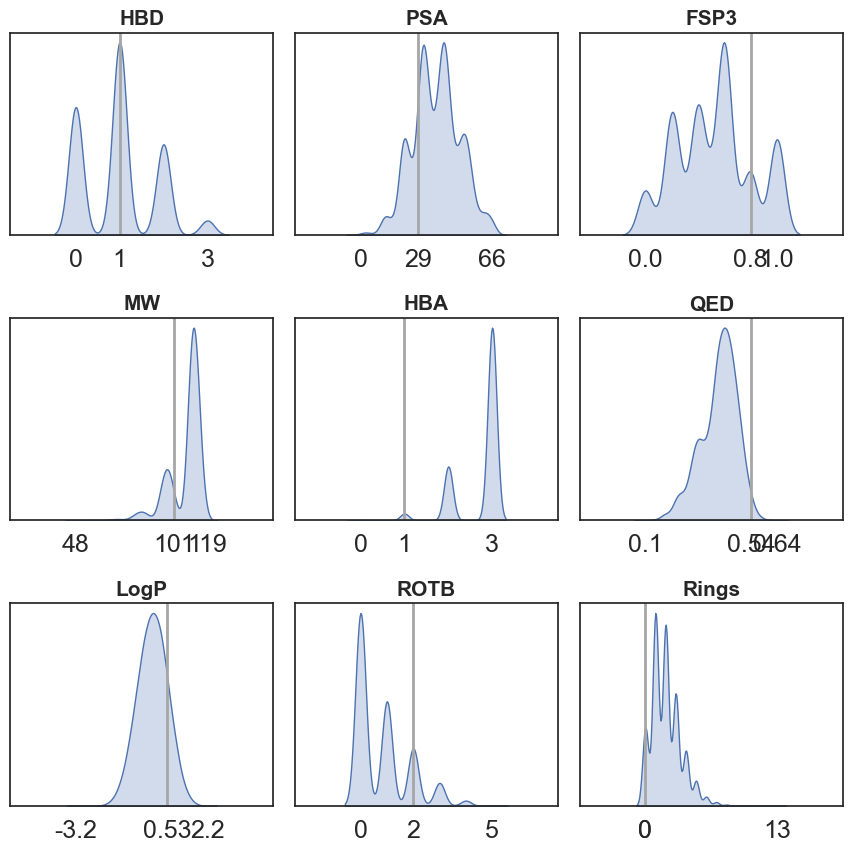

In [11]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.2)
g = sns.FacetGrid(df_plot,col = "property",
                  aspect=1,height=1.16798*2.5,col_wrap=3,
                  sharex=False,sharey=False,palette="plasma")

g.map(sns.kdeplot, "value",clip_on=True,fill=True,bw_method=0.2);
g.set(yticks=[])

g.despine(top=False, right=False)
titles = ['HBD', 'PSA', 'FSP3', 'MW', 'HBA', 'QED', 'LogP', 'ROTB', 'SSSR']
         

for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
    title = titles[i]
    
    
    M_loc = amide_interp[title]
    ax.set_ylabel("")
    ax.set_xticks([])
    
    # was removed for publishing purposes
    ax.set_xticks(x_locs_vals[title])
    ax.set_xticklabels(x_locs_text[title],rotation=0,fontsize=18)
    
    ax.set_xlim(-.5,1.5)
    greys = 0.65
    ax.axvline(x_locs_vals[title][1], color=(greys,greys,greys), linewidth=2)
    if title == "SSSR":
        ax.set_title("Rings", fontweight='bold',fontsize=15)
    else:
        ax.set_title(title, fontweight='bold',fontsize=15)

g.set_xlabels("")
plt.tight_layout()
plt.subplots_adjust(hspace=0.41)

# g.fig.suptitle(r"Molecular Properties",fontweight='bold',fontsize=16)
plt.savefig(f"./figures/SI_KDEs_3.svg",format="svg")

### calculate PMI


In [6]:
# around 20 minutes on 32 cores 
if __name__ == '__main__':
    with mp.Pool(32) as p:
        result = p.map(molprops_utils.cal_pmi, data.smiles,chunksize=1000)

In [7]:
data["pmi_x"] = [i[0] for i in result]
data["pmi_y"] = [i[1] for i in result]
# data.drop("pmi",axis=1,inplace=True)

In [8]:
data[["smiles","pmi_x","pmi_y"]].to_csv("./data_files/smiles_pmi.csv")

In [9]:
data_pmi = pd.read_csv("./data_files/smiles_pmi.csv",index_col=0)

### collect data separately for the 4 amides

In [10]:
amide_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in "CCC(NCC)=O.C=CC(NCC)=O.C=CC(NC=C)=O.CCC(NC=C)=O".split(".")]

amide_data = data_pmi[data_pmi.smiles.isin(amide_smiles)]
amide_data

,smiles,pmi_x,pmi_y
82,CCNC(=O)CC,0.130135,0.897591
772,C=CC(=O)NCC,0.186604,0.888132
858,C=CNC(=O)CC,0.164827,0.851351
2669,C=CNC(=O)C=C,0.234627,0.765373


In [11]:
data_pmi.dropna(subset = ['pmi_x'],inplace=True)

In [12]:
data_pmi.reset_index(drop=True,inplace=True)

In [13]:
amide_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in "CCC(NCC)=O.C=CC(NCC)=O.C=CC(NC=C)=O.CCC(NC=C)=O".split(".")]

In [14]:
pmi_dict = {}

for s in amide_smiles:
    
    s_pmi = []
    for _ in range(100):
        s_pmi.append(molprops_utils.cal_pmi(s))
    pmi_dict[s] = s_pmi
    

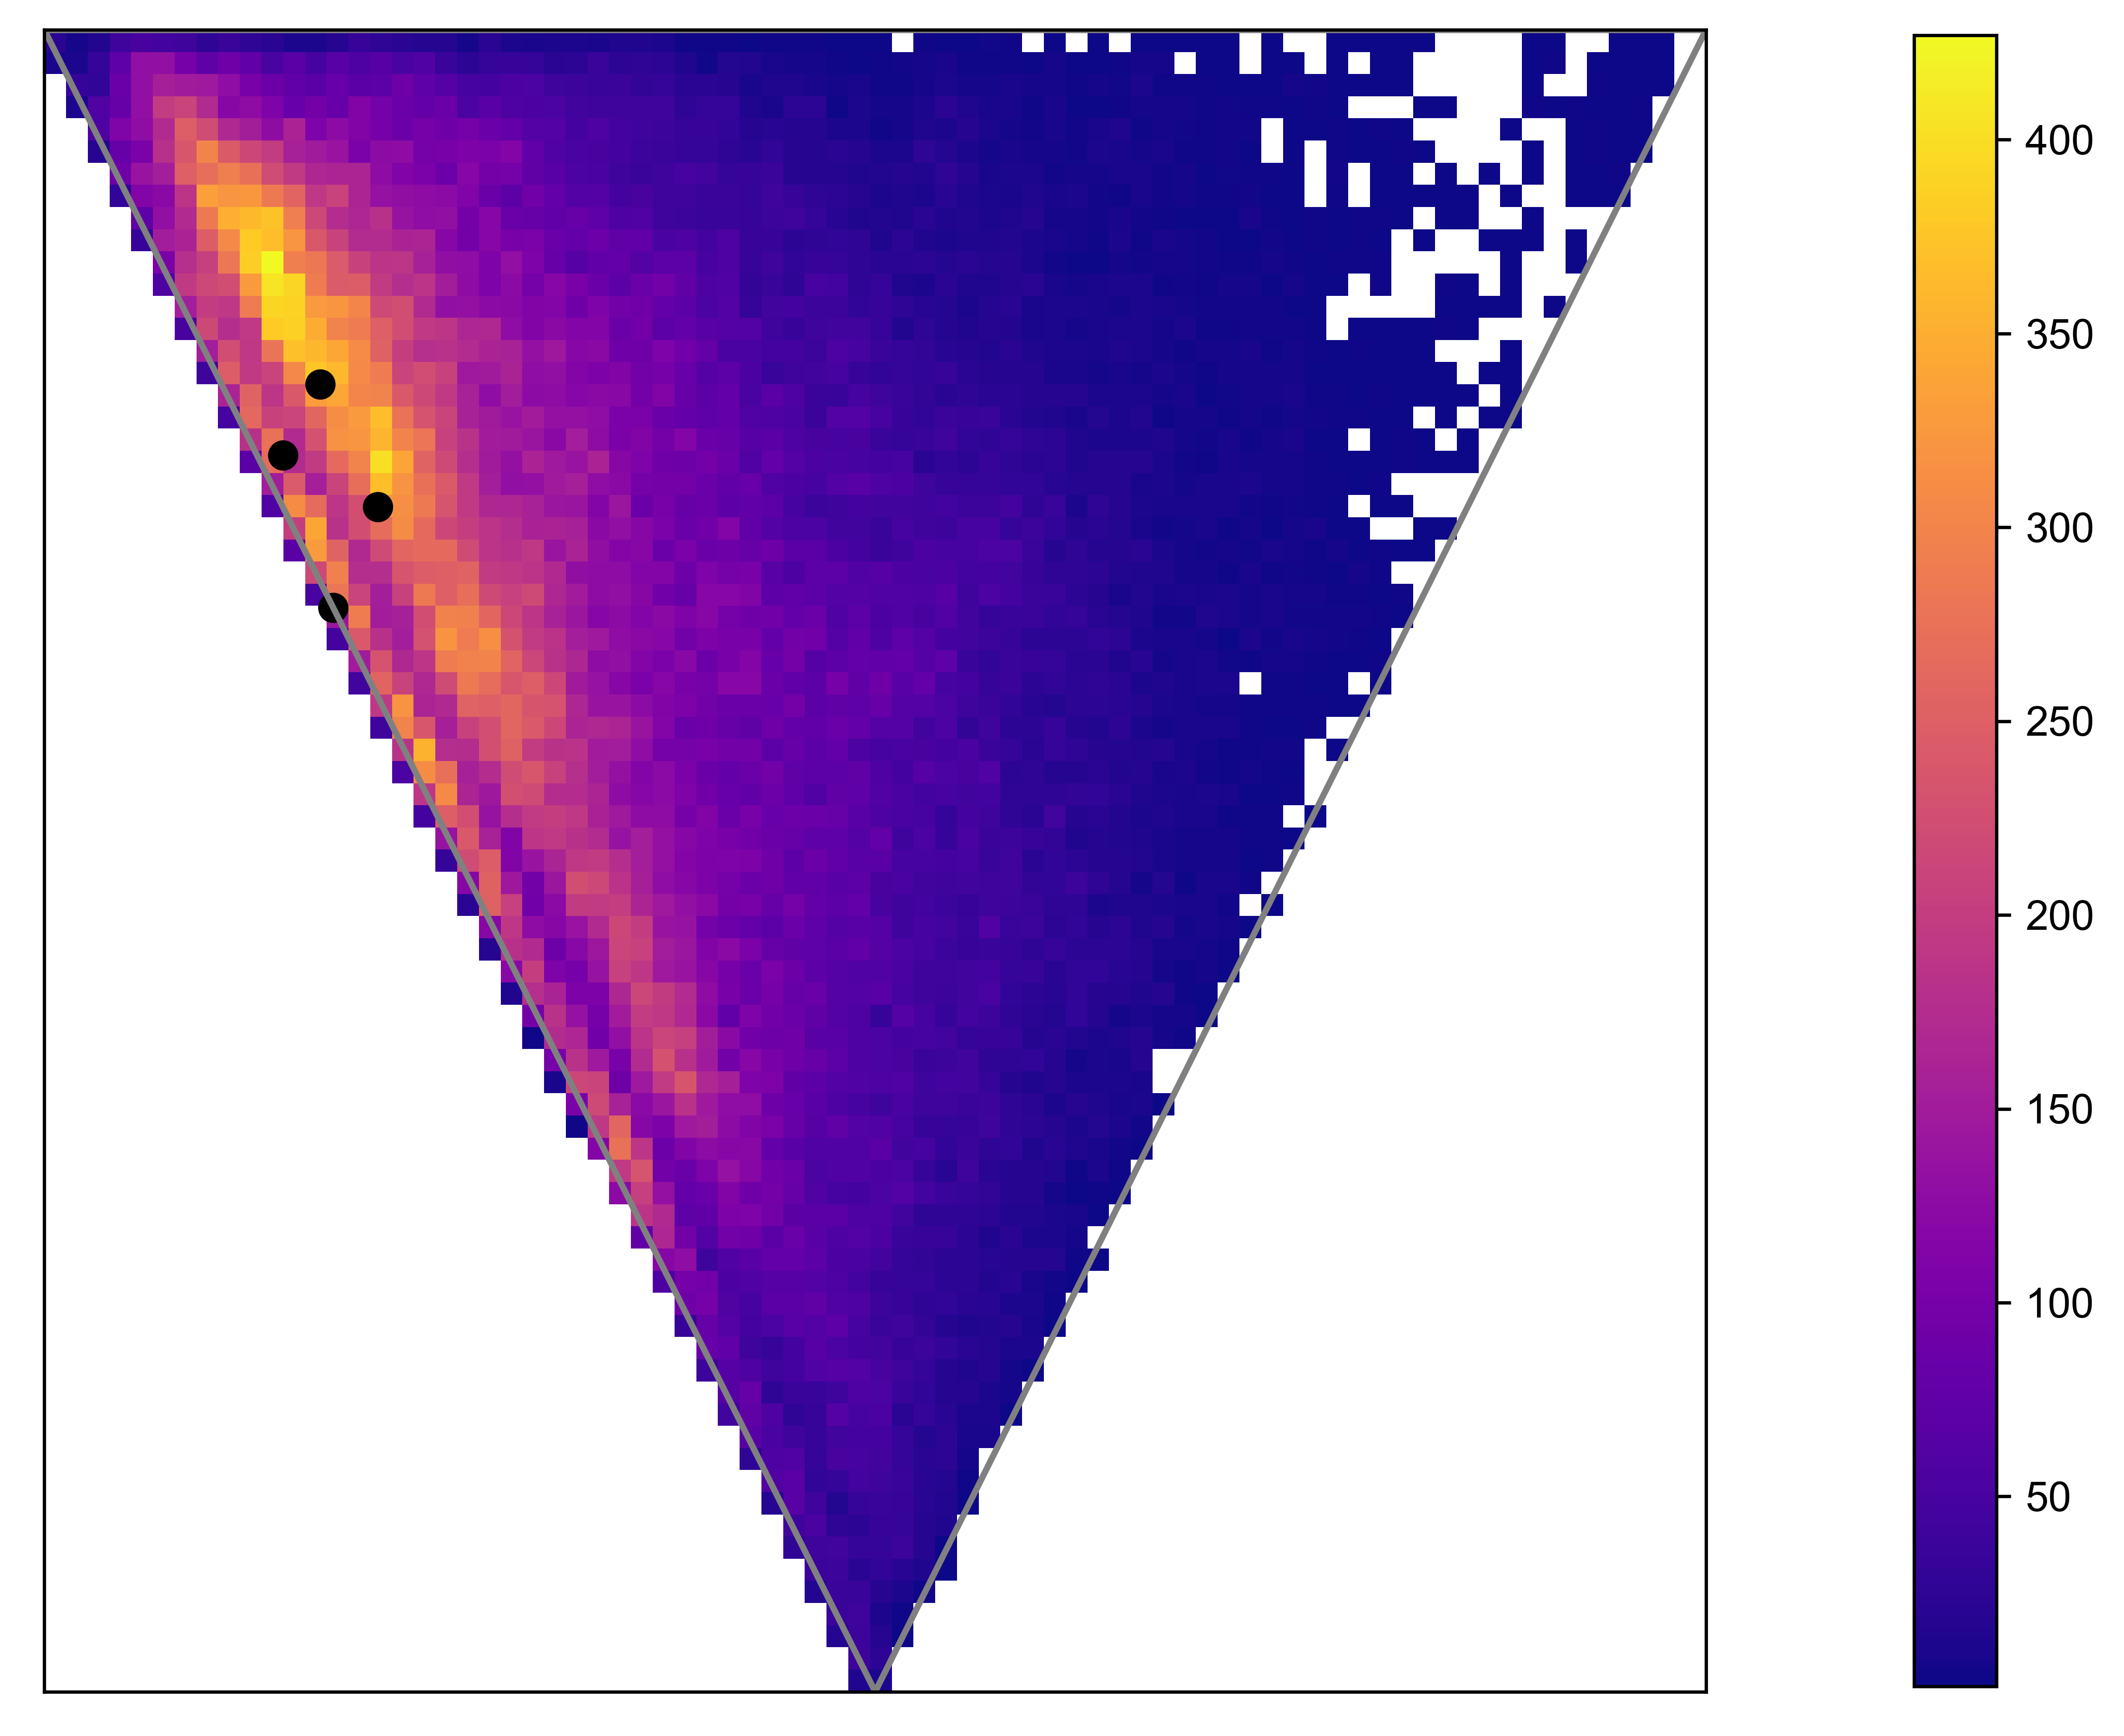

In [17]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18,18),dpi=600)
fig, ax = plt.subplots(figsize=(18,18),dpi=600)

h = ax.hist2d(list(data_pmi.pmi_x), list(data_pmi.pmi_y),bins=75,cmin=1,cmap="plasma")


ax.set_xlim((0,1))
ax.set_ylim((0.5,1))
ax.plot([0,.5], [1,0.5],color='gray')
ax.plot([.5,1], [0.5,1],color='gray')
ax.plot([0,1], [1,1],color='gray')
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
divider = make_axes_locatable(ax)
plt.colorbar(h[3],shrink=0.4)

# the 4 amides 
for s in pmi_dict:
    pmi_data = np.array(pmi_dict[s])
    
    ax.scatter(np.mean(pmi_data[:,0]),np.mean(pmi_data[:,1]),alpha=1,s=40,color="k")

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('./figures/SI_pmi_200k.svg', format="svg")
# plt.close(fig)
pass